# Convert Segmentation Masks to YOLOv8 PyTorch TXT Format

This notebook provides some utilities and scripts to transform the raw image data and masks shared by ReefSupport into the YOLOv8 format.

## Setup

### Imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import trange, tqdm
import shutil

### Global variables

Adjust the `INPUT_DIR_DATASET_ROOT_RS_LABELLED` and `OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS` paths to match your filesystem setup.

In [2]:
LABEL_TO_CLASS_MAPPING = {
    'soft_coral': 0,
    'hard_coral': 1
    }
CLASS_TO_LABEL_MAPPING = {v: k for k, v in LABEL_TO_CLASS_MAPPING.items()}
COLOR_TO_LABEL_MAPPING = {
    (0, 0, 0):   'other',       # Black
    (0, 0, 255): 'soft_coral',  # Blue
    (255, 0, 0): 'hard_coral',  # Red
}
LABEL_TO_COLOR_MAPPING = {v: k for k, v in COLOR_TO_LABEL_MAPPING.items()}

# IMPORTANT: Modify these two paths to point to your own data
INPUT_DIR_DATASET_ROOT_RS_LABELLED = Path('/home/chouffe/playground/datasets/benthic_datasets/mask_labels/rs_labelled')
OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS = Path('/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation')

# For type hints
Contour = np.ndarray
Mask = np.ndarray
Polygon = np.ndarray

### functions and utils

In [3]:
def get_all_dataset_names(path: Path) -> list[str]:
  return [f for f in os.listdir(path) if os.path.isdir(path / f)]

def filepath_to_ndarray(filepath: Path) -> np.ndarray:
    return cv2.imread(str(filepath))

def scaffold_output_dir() -> None:
    if not os.path.isdir(OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS):
      os.makedirs(OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS)

def list_all_mask_filepaths(dataset_name: str) -> list[Path]:
    path = INPUT_DIR_DATASET_ROOT_RS_LABELLED / dataset_name / 'masks'
    return [path / f for f in os.listdir(path) if os.path.isfile(path / f)]

def is_only_black_pixels(mask: Mask) -> bool:
  """
  Returns True if the mask image is only black pixels.
  """
  non_black_pixels = np.any(mask != [0, 0, 0], axis=-1)
  black_pixels = ~non_black_pixels
  return black_pixels.all()


def mask_label(mask: Mask) -> str:
  """
  Returns the class of the mask (nd_array) as a string in {other, soft_coral,
  hard_coral}
  Assumption: one mask file will only label one type of coral (either blue or
  red).
  """
  idx = np.any(mask != [0, 0, 0], axis=-1)
  color_tuple = tuple(mask[idx][0])
  return COLOR_TO_LABEL_MAPPING.get(color_tuple, 'other')

In [4]:
def normalize_polygon(polygon, W: int, H: int) -> Polygon:
  """
  `polygon`: numpy array of shape (_,2) containing the polygon x,y coordinates.
  `W`: int - width of the image / mask
  `H`: int - height of the image / mask

  returns a numpy array of shape `polygon.shape` with coordinates that are
  normalized between 0-1.

  Will throw an assertion error if all values of the result do not lie in 0-1.
  """
  copy = np.copy(polygon)
  copy = copy.astype(np.float16)
  copy[:,0] *= 1 / W
  copy[:,1] *= 1 / H

  assert ((copy >= 0) & (copy <= 1)).all(), f"normalized_polygon values are not all in range 0-1, got: {copy}"

  return copy
    

def normalize_bounding_box(bbox, W: int, H: int):
  """
  Returns xcyxwh bounding box coordinate to follow the yolov8 format.
  """
  (x0, y0, x1, y1) = bbox
  xcenter = (x0 + x1) / 2. / W
  ycenter = (y0 + y1) / 2. / H
  w = abs(x0 - x1) / W
  h = abs(y0 - y1) / H
  return (xcenter, ycenter, w, h)


def contours_to_polygons(contours: list[Contour]) -> list[Polygon]:
    """
    Turn a list of contours into a list of polygons
    """
    polygons = []
    for contour in contours:
        polygon_list = []
        for point in contour:
          x, y = point[0]
          polygon_list.append(np.array([x,y]))
        polygon = np.array(polygon_list)
        polygons.append(polygon)
    return polygons


def is_contour_area_large_enough(contour: Contour, threshold: int = 200) -> bool:
    return cv2.contourArea(contour) > threshold


def mask_to_contours(mask: Mask) -> list[Contour]:
    """
    Given a mask, it returns its contours.
    """
    # Loading the mask in grey, only format supported by cv2.findContours
    mask_grey = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(mask_grey, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Only keep the areas that are big enough
    valid_contours = [contour for contour in contours if is_contour_area_large_enough(contour)]
    return valid_contours

def display_contours(mask: Mask, contours: list[Contour]) -> None:
    """
    Display the contours information, useful for debugging.
    """
    N = len(contours)
    label = mask_label(mask)
    f, axs = plt.subplots(1, N+1, figsize=(15, 15))
    
    plt.subplot(1, N+1, 1)
    plt.imshow(mask)
    plt.title('Mask')

    color = LABEL_TO_COLOR_MAPPING[label]
    thickness = 10
    for i, contour in enumerate(contours):
        image_black = np.zeros(mask.shape, dtype=np.uint8)
        image_contour = cv2.drawContours(image_black, [contour], -1, color, thickness)
        plt.subplot(1, N+1, i+2)
        plt.imshow(image_contour)
        plt.title(f'Contour {i}')

    plt.show()

# Yolov8 PyTorch TXT format

def stringify_polygon(polygon: Polygon) -> str:
  """
  Turns a polygon nd_array into a string in the right YOLOv8 format.
  """
  return ' '.join([f'{x} {y}' for (x, y) in polygon])


def stringify_bounding_box(bbox) -> str:
  """
  Turns a polygon nd_array into a string in the right YOLOv8 format.
  """
  xc, yc, w, h = bbox
  return f'{xc} {yc} {w} {h}'


def mask_filepath_to_yolov8_format_string(filepath: Path) -> str:
    """
    Given a `filepath` for an individual mask, it returns a yolov8 format string describing 
    the polygons for the segmentation tasks.
    """
    mask = filepath_to_ndarray(filepath)
    if is_only_black_pixels(mask):
        return ''
    else:
        label_class = LABEL_TO_CLASS_MAPPING[mask_label(mask)]
        H, W, _ = mask.shape
        contours = mask_to_contours(mask)
        polygons = contours_to_polygons(contours)
        normalized_polygons = [normalize_polygon(p, W, H) for p in polygons]
        return '\n'.join([f'{label_class} {stringify_polygon(p)}' for p in normalized_polygons])


def generate_dataset_individual_mask_labels(dataset_name: str, output_dir: Path = OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS) -> None:
    """
    Given a `dataset_name` (see function get_all_dataset_names`, it generates the instance 
    segmentation labels in `output_dir`.
    """
    filepaths = list_all_mask_filepaths(dataset_name)
    output_filepath_root = output_dir / dataset_name / 'labels/individual/' 

    if not os.path.exists(output_filepath_root): 
        os.makedirs(output_filepath_root)
    
    for filepath in tqdm(filepaths):
        output_filepath = output_filepath_root / f'{filepath.stem}.txt'
        content = mask_filepath_to_yolov8_format_string(filepath)
        if os.path.exists(output_filepath):
            os.remove(output_filepath)
        with open(output_filepath, 'x') as f:
            f.write(content)


def prefix_to_mask_filepaths(dataset_name: str, prefix: str, output_dir=OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS) -> list[Path]:
    path: Path = OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS / dataset_name / 'labels/individual'
    return [Path(path / f) for f in os.listdir(path) if f.startswith(prefix)]


def filepath_to_content(filepath: Path) -> str:
    """
    Given a path, it returns its content as a string
    """
    with open(filepath, 'r') as f:
      return f.read()


def stitch_mask_label_yolov8_format_string(dataset_name: str, mask_stitched_filepath: Path) -> str:
    """
    Returns the YOLOv8 PyTorch TXT format as a string for the given 
    `mask_stitched_filepath` and `dataset_name`.
    """
    prefix = mask_stitched_filepath.stem
    individual_mask_filepaths = prefix_to_mask_filepaths(dataset_name, prefix)
    return '\n'.join([filepath_to_content(path) for path in individual_mask_filepaths])


def generate_stitched_masks_labels_for_dataset_name(dataset_name: str, output_dir=OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS) -> None:
    output_filepath_root = OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS / dataset_name / 'labels' / 'stitched'
    if not os.path.exists(output_filepath_root):
        os.makedirs(output_filepath_root)

    path = INPUT_DIR_DATASET_ROOT_RS_LABELLED / dataset_name / 'masks_stitched'
    masks_stitched_filepaths = [Path(path / f) for f in os.listdir(path)]
    
    for mask_stitched_filepath in tqdm(masks_stitched_filepaths):
        content = stitch_mask_label_yolov8_format_string(dataset_name, mask_stitched_filepath)
        output_filepath = output_filepath_root / f'{mask_stitched_filepath.stem}.txt'
        if os.path.exists(output_filepath):
            os.remove(output_filepath)
        with open(output_filepath, 'x') as f:
            f.write(content)

def generate_all_stitched_masks_labels(output_dir=OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS) -> None:
    for dataset_name in tqdm(get_all_dataset_names(INPUT_DIR_DATASET_ROOT_RS_LABELLED)):
        print(f'Generating stitched mask labels for {dataset_name}')
        generate_stitched_masks_labels_for_dataset_name(dataset_name)

# TODO: fix the dataset generation for other datasets
def generate_image_labels_for_dataset(dataset_name: str, output_dir=OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS) -> None:
    output_path_stitched_labels_root = OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS / dataset_name / 'labels' / 'stitched'
    output_path_image_labels_root = output_dir / dataset_name / 'labels' / 'images'

    if not os.path.exists(output_path_image_labels_root):
        os.makedirs(output_path_image_labels_root)
    
    masks_stitched_filepaths = [output_path_stitched_labels_root / f for f in os.listdir(output_path_stitched_labels_root)]
    for p in masks_stitched_filepaths:
        image_label_filename = p.name.replace('_mask', '')
        image_label_filepath = output_path_image_labels_root / image_label_filename
        if os.path.exists(image_label_filepath):
            os.remove(image_label_filepath)
        content = filepath_to_content(p)
        with open(image_label_filepath, 'x') as f:
            f.write(content)

def generate_image_labels(output_dir=OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS) -> None:
    for dataset_name in tqdm(get_all_dataset_names(INPUT_DIR_DATASET_ROOT_RS_LABELLED)):
        print(f'Generating image labels for {dataset_name}')
        generate_image_labels_for_dataset(dataset_name)

## Data transformation 

### Datasets

In [5]:
# We prepare the output dir structure for the labels
scaffold_output_dir()

In [6]:
# List all dataset_names in the INPUT_DIR
all_dataset_names = get_all_dataset_names(INPUT_DIR_DATASET_ROOT_RS_LABELLED)
all_dataset_names

['SEAFLOWER_BOLIVAR',
 'SEAVIEW_PAC_AUS',
 'SEAFLOWER_COURTOWN',
 'SEAVIEW_IDN_PHL',
 'SEAVIEW_ATL',
 'TETES_PROVIDENCIA',
 'SEAVIEW_PAC_USA']

We assume the following folder structure in a dataset:

```
.
├── DATASET_NAME
│   ├── images
│   ├── masks
│   └── masks_stitched
```


In [9]:
!tree -d -L 2 $INPUT_DIR_DATASET_ROOT_RS_LABELLED

/home/chouffe/playground/datasets/benthic_datasets/mask_labels/rs_labelled
├── SEAFLOWER_BOLIVAR
│   ├── images
│   ├── masks
│   └── masks_stitched
├── SEAFLOWER_COURTOWN
│   ├── images
│   ├── masks
│   └── masks_stitched
├── SEAVIEW_ATL
│   ├── images
│   ├── masks
│   └── masks_stitched
├── SEAVIEW_IDN_PHL
│   ├── images
│   ├── masks
│   └── masks_stitched
├── SEAVIEW_PAC_AUS
│   ├── images
│   ├── masks
│   └── masks_stitched
├── SEAVIEW_PAC_USA
│   ├── images
│   ├── masks
│   └── masks_stitched
└── TETES_PROVIDENCIA
    ├── images
    ├── masks
    └── masks_stitched

28 directories


### Visualization

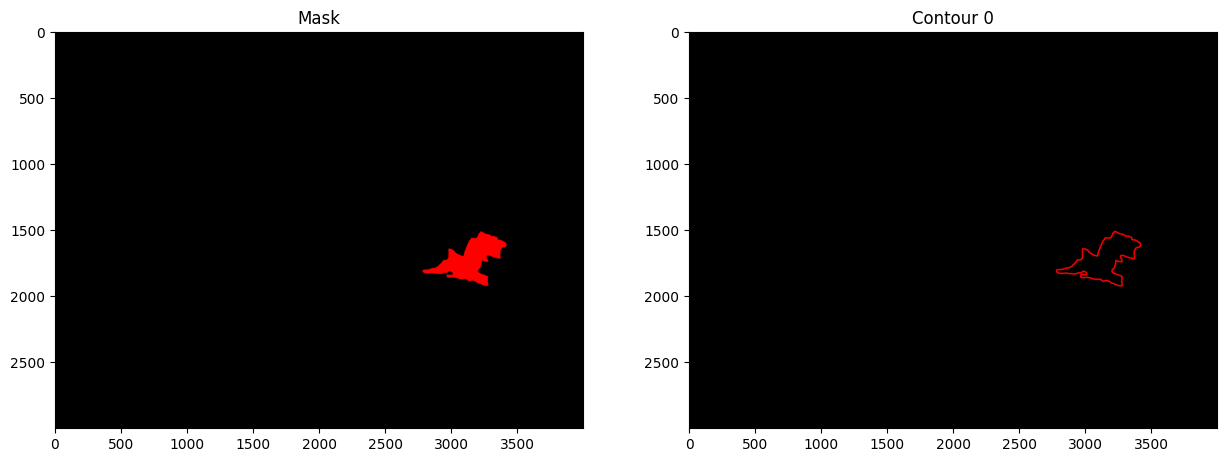

In [11]:
dataset_name = all_dataset_names[0]
filepaths = list_all_mask_filepaths(dataset_name)
mask = filepath_to_ndarray(filepaths[0])
contours = mask_to_contours(mask)
display_contours(mask, contours)

### Generate individual mask labels

In this section we generate all the individual mask labels. It will take a very long time (~1h / 1h30) depending on your machine setup.

In [106]:
# Generate the labels in parallel
# Will take a long time to call opencv on each individual mask
import multiprocessing as mp

dataset_names = get_all_dataset_names(INPUT_DIR_DATASET_ROOT_RS_LABELLED)
with mp.Pool(mp.cpu_count()) as pool:
    list(tqdm(pool.imap(generate_dataset_individual_mask_labels, dataset_names), total=len(dataset_names)))

  0%|          | 0/7 [00:00<?, ?it/s]

### Generate stitched mask labels

Very fast operation that stitches together all the individual mask labels

In [199]:
generate_all_stitched_masks_labels()

  0%|          | 0/7 [00:00<?, ?it/s]

Generating stitched mask labels for SEAFLOWER_BOLIVAR


  0%|          | 0/246 [00:00<?, ?it/s]

Generating stitched mask labels for SEAVIEW_PAC_AUS


  0%|          | 0/808 [00:00<?, ?it/s]

Generating stitched mask labels for SEAFLOWER_COURTOWN


  0%|          | 0/241 [00:00<?, ?it/s]

Generating stitched mask labels for SEAVIEW_IDN_PHL


  0%|          | 0/466 [00:00<?, ?it/s]

Generating stitched mask labels for SEAVIEW_ATL


  0%|          | 0/705 [00:00<?, ?it/s]

Generating stitched mask labels for TETES_PROVIDENCIA


  0%|          | 0/105 [00:00<?, ?it/s]

Generating stitched mask labels for SEAVIEW_PAC_USA


  0%|          | 0/728 [00:00<?, ?it/s]

### Generate image labels

In [225]:
generate_image_labels()

  0%|          | 0/7 [00:00<?, ?it/s]

Generating image labels for SEAFLOWER_BOLIVAR
/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/SEAFLOWER_BOLIVAR/labels/images
Generating image labels for SEAVIEW_PAC_AUS
/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/SEAVIEW_PAC_AUS/labels/images
Generating image labels for SEAFLOWER_COURTOWN
/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/SEAFLOWER_COURTOWN/labels/images
Generating image labels for SEAVIEW_IDN_PHL
/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/SEAVIEW_IDN_PHL/labels/images
creating dir
Generating image labels for SEAVIEW_ATL
/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/SEAVIEW_ATL/labels/images
creating dir
Generating image labels for TETES_PROVIDENCIA
/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/TETES_PROVIDENCIA/labels/images
creating dir
Generating image labels for SEA

### Export and share

Make a zip archive to easily share the labels.

In [12]:
# Overview of the labels we generated
!tree -d -L 3 $OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS

/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation
├── SEAFLOWER_BOLIVAR
│   └── labels
│       ├── images
│       ├── individual
│       └── stitched
├── SEAFLOWER_COURTOWN
│   └── labels
│       ├── images
│       ├── individual
│       └── stitched
├── SEAVIEW_ATL
│   └── labels
│       ├── images
│       ├── individual
│       └── stitched
├── SEAVIEW_IDN_PHL
│   └── labels
│       ├── images
│       ├── individual
│       └── stitched
├── SEAVIEW_PAC_AUS
│   └── labels
│       ├── images
│       ├── individual
│       └── stitched
├── SEAVIEW_PAC_USA
│   └── labels
│       ├── images
│       ├── individual
│       └── stitched
└── TETES_PROVIDENCIA
    └── labels
        ├── images
        ├── individual
        └── stitched

35 directories


In [228]:
# Make an archive zip file to make it easy to share and distribute
shutil.make_archive(
    OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS / 'archive', 
    'zip', 
    OUTPUT_DIR_YOLOV8_INSTANCE_SEGMENTATION_LABELS
)

'/home/chouffe/playground/datasets/yolov8/benthic_datasets/instance_segmentation/archive.zip'